## 1) Introduction


In this project, we aim to design and implement a crowd counting model using deep learning techniques. Our goal is to develop a robust and accurate model capable of accurately estimating crowd densities in images and videos in real-time as shown in the image below. In addition to its practical applications in security, urban planning, and event management, accurate crowd counting is essential to understanding crowd behavior and facilitating crowd control measures during emergencies, making it a crucial tool for public safety. We will leverage encoder and decoder concepts, skip connections, other advanced architectures (inlcuding investigating pretrained models), and optimization techniques to further enhance the performance and efficiency of our model.


Screenshot 2024-04-03 at 11.13.19 PM.png

## 2) Data Loading and Processing

We used a dataset from ShanghaiTech University which included RGB images of various sizes along with the labeled positions of heads. We cropped the images in the dataset to 224x224 and using the head positions we created density maps using a gaussian filter. Images that didn't contain any heads after cropping were removed.

After pre-processing, our dataset consisted 575 samples for training and 439 samples for validation, which maintained the train-test split from the original dataset for a fair model comparison.


ShanghaiTech Dataset
https://github.com/desenzhou/ShanghaiTechDataset?tab=readme-ov-file

In [ ]:
# We mount our Google Drive which has the unzipped dataset

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:

import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import torch.utils.data as data_utils
from torchvision import transforms, utils, datasets, models
import scipy.io
import torchvision
import random
import shutil
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim #for gradient descent
import time
import pandas as pd
from scipy.ndimage import gaussian_filter
import seaborn as sns

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# Dataset Class for our images
class ShanghaiTechDataset(Dataset):

    def __init__(self, root_dirs, width = 224, height = 224, sigma = 1, max_pixel = 256.0, max_samples = 10000):
        self.width = width
        self.height = height
        self.images = []
        self.density_maps = []
        self.counts = []
        self.sigma = sigma

        image_paths = []
        for dir in root_dirs:
            image_dir = os.path.join(dir, "images")
            for image_name in os.listdir(image_dir):
                image_paths.append(os.path.join(image_dir, image_name))

        # collect data
        for img_path in image_paths:
            # load ground truth and create density map
            gt_path = img_path.replace('.jpg', '.mat').replace('images', 'ground_truth').replace('IMG_', 'GT_IMG_')
            mat = scipy.io.loadmat(gt_path)
            points = mat['image_info'][0][0][0][0][0]

            density_map = np.zeros((self.height, self.width))
            num_people = 0
            for point in points:
                x, y = int(point[0]), int(point[1])  # Assuming x corresponds to width and y to height
                if 0 <= x < self.width and 0 <= y < self.height:
                    density_map[y][x] = 1.0
                    num_people += 1
            if num_people == 0:
                continue
            self.counts.append(num_people)
            density_map = gaussian_filter(density_map, sigma=self.sigma)
            self.density_maps.append(torch.from_numpy(density_map).float())
            image = io.imread(img_path).astype(np.float32)
            if len(image.shape) == 2:
                #greyscale image, change to RGB
                image = np.stack([image]*3, axis=2)
            height, width, channels = image.shape
            # 0 pad if too small
            pad_bottom,pad_right = 0,0
            if height < self.height:
                pad_bottom = self.height - height
            if width < self.width:
                pad_right = self.width - width
            if pad_bottom != 0 or pad_right != 0:
                image = np.pad(image, ((0, pad_bottom), (0, pad_right), (0, 0)), mode='constant', constant_values=0)
            # crop to desired size
            image = image[0:self.height, 0:self.width, :]
            image = np.transpose(image, [2,0,1])
            image /= max_pixel
            self.images.append(torch.from_numpy(image).float())
            if len(self.images) >= max_samples:
                break

        self.num_samples = len(self.images)
    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        return self.images[idx],self.density_maps[idx], self.counts[idx]

In [ ]:
# Loading train and test data from the unzipped dataset folder and saving it as a .pt file for convenience
train_data = ShanghaiTechDataset(["/content/drive/MyDrive/MIE1517 Project/Data/part_A_final/train_data", "/content/drive/MyDrive/MIE1517 Project/Data/part_B_final/train_data"], sigma = 3, max_samples=10000)
test_data = ShanghaiTechDataset(["/content/drive/MyDrive/MIE1517 Project/Data/part_A_final/test_data", "/content/drive/MyDrive/MIE1517 Project/Data/part_B_final/test_data"], sigma = 3, max_samples=10000)
torch.save(train_data, '/content/drive/MyDrive/Data_Project/train.pt')
torch.save(train_data, '/content/drive/MyDrive/Data_Project/test.pt')

In [ ]:
# Load training and testing data from the saved torch file if not already loaded above
train_data = torch.load('/content/drive/MyDrive/MIE1517Project/Data/train.pt')
test_data = torch.load('/content/drive/MyDrive/MIE1517Project/Data/test.pt')

In [ ]:
print(f' Length of training data: {len(train_data)}\n Length of testing data: {len(test_data)}')

 Length of training data: 575
 Length of testing data: 439


## 3) Data Visualization

In [ ]:
# Getting images, density maps, and counts from the dataset
train_data_image = np.array(train_data.images)
train_data_image.shape # Images: [458, 3, 224, 224]
train_data_density = np.array(train_data.density_maps)
train_data_density.shape # Density: [458, 1, 224, 224]
train_data_count = np.array(train_data.counts)
train_data_count.shape # [458, 1]

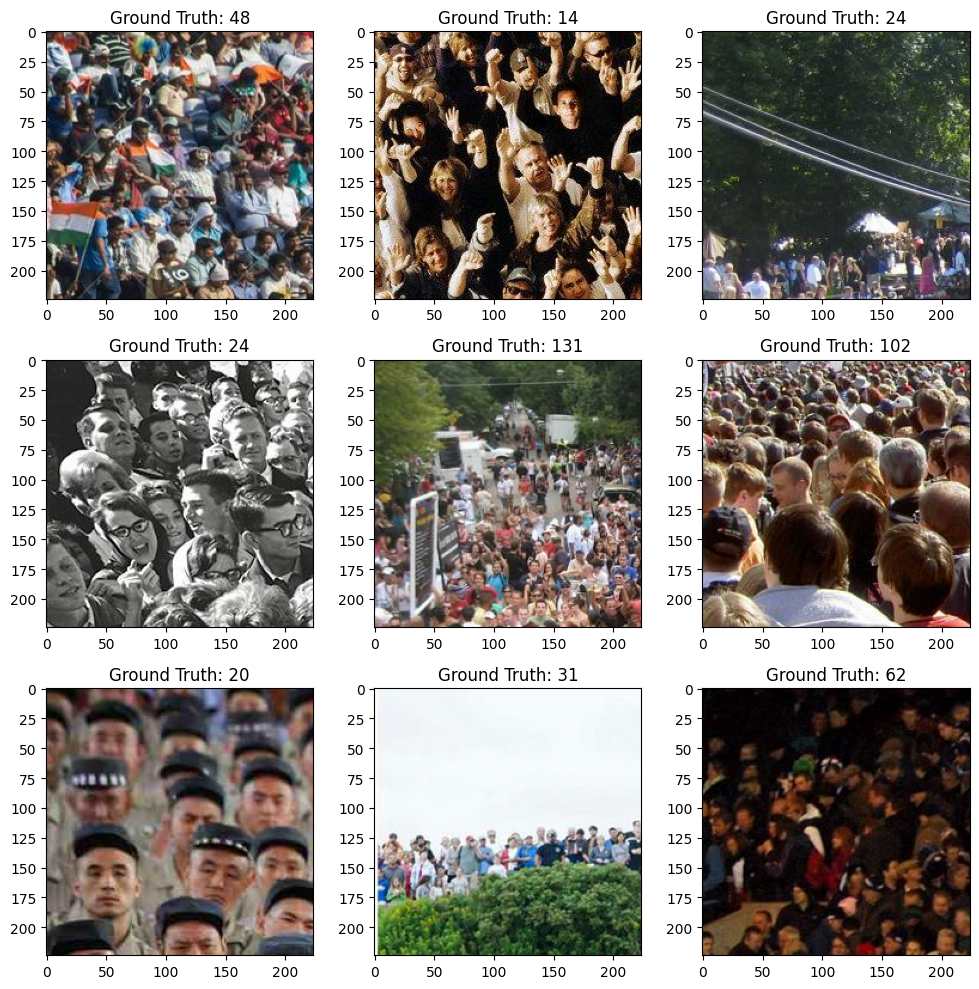

In [ ]:
# Visualizing training images with their crowd count

figure,axis = plt.subplots(3,3,figsize=(10,10))

for indexing,operation in enumerate(axis.flat):

    Image_Picking_Image = train_data_image[indexing]
    operation.imshow(Image_Picking_Image.transpose(1,2,0))
    operation.set_title(f'Ground Truth: {train_data_count[indexing]}')

plt.tight_layout()
plt.show()

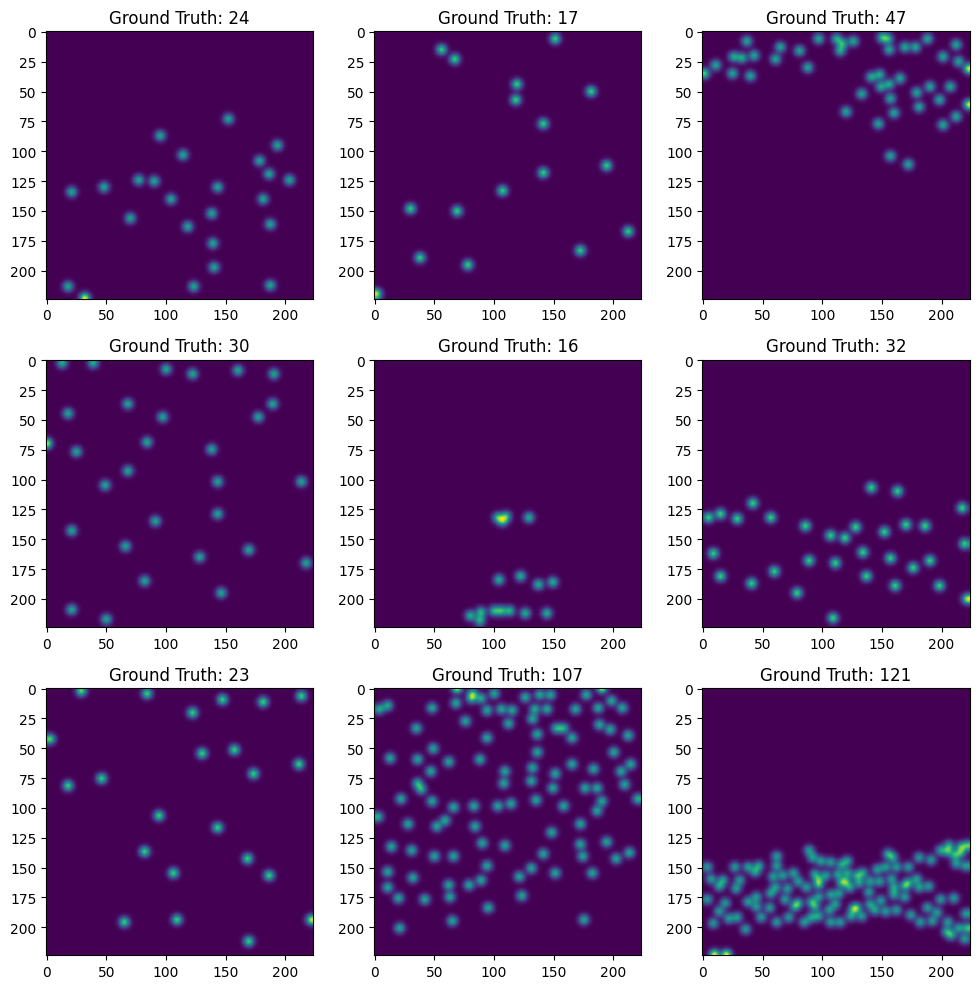

In [ ]:
# Visualizing training density maps with their crowd count

figure,axis = plt.subplots(3,3,figsize=(10,10))

for indexing,operation in enumerate(axis.flat):
    Image_Picking_Image = train_data_density[indexing]
    operation.imshow(Image_Picking_Image)
    operation.set_title(f'Ground Truth: {train_data_count[indexing]}')

plt.tight_layout()
plt.show()